<a href="https://colab.research.google.com/github/d-austen/DeepLearningProject/blob/main/summerdays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's start off by importing some packages we'll need.

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [2]:
!pip install gdown

In [3]:
!gdown https://drive.google.com/uc?id=11TDcwpcIOGNuBmmnbCT-UUKrKOsHjOYU
!gdown https://drive.google.com/uc?id=1Y7fX_ZhytPBczgh7fctKSLVNJhZzQn3E

Downloading...
From: https://drive.google.com/uc?id=11TDcwpcIOGNuBmmnbCT-UUKrKOsHjOYU
To: /content/summerdays.csv
100% 14.3k/14.3k [00:00<00:00, 26.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Y7fX_ZhytPBczgh7fctKSLVNJhZzQn3E
To: /content/timeseries.csv
100% 35.4M/35.4M [00:00<00:00, 69.5MB/s]


In [4]:
su = pd.read_csv('summerdays.csv',index_col=0)
ts = pd.read_csv('timeseries.csv',index_col=0)
su = torch.tensor(su.values, dtype=torch.float32).T
ts = torch.tensor(ts.values, dtype=torch.float32).T
su = (su-su.mean())/su.std()
ts = (ts-ts.mean())/ts.std()
ts = ts.unsqueeze(1)

x = ts
y = su

To use 2d convolutions, we need to have a channel dimension for our input tensor, which should be of size `(n_batch, n_channels, n_rows, n_columns)`. Use `reshape` or `unsqueeze` to add a channel axis of size 1 to `x`. It should be in position one, after the batch axis (position 0) but before the spatial dimensions.

Similarly, change `y` to have a second dimension of size 1, so that it has two dimensions total. This way it will match the output coming from out network.

Create a class defining your convolutional network.

Add code to the `__init__` method to define the layers, and add code to the `forward` method to use them.
* Start with a convolution with 30 output channels, and 'same' padding so that the image width and height are the same in the input and output. Use filters with a height of 4 and width of 8.
* Then use a `tanh` nonlinearity
* Next use a 2x2 maxpooling layer
* Then another convolution with 30 outputs, filter height 2 and filter width 4.
* Next another `tanh`
* Now another 2x2 maxpooling layer
* A third convolution with 30 outputs, filter height 2 and filter width 4
* Now reshape the output so the batch dimension is unchanged, but all other dimensions are combined into one.
* Now use a fully connected layer with 30 outputs
* Now a `tanh`
* Now a second fully connected layer with 1 output: that's $\hat our y$, which our forward method should return!

In [5]:
# build the convnet from the paper
class ConvNet(torch.nn.Module):
    def __init__(self, input_channels=1, hidden_channels=30, hidden_units=30, n_outputs=1):
        super(ConvNet, self).__init__()

        self.first_conv = nn.Conv1d(input_channels,hidden_channels,(2),padding='same')
        self.first_maxpool = nn.MaxPool1d((2))
        self.first_batchnorm = nn.BatchNorm1d(hidden_channels)
        self.second_batchnorm = nn.BatchNorm1d(hidden_channels)
        self.second_conv = nn.Conv1d(hidden_channels,hidden_channels,(2),padding='same')
        self.first_FC = nn.Linear(30*1826,hidden_units)
        self.second_FC = nn.Linear(hidden_units, n_outputs)


        # ...

    def forward(self, x):
        #print(x[0][0])
        x = self.first_conv(x)
        x = self.first_batchnorm(x)
        #print(x[0][0])
        x = torch.tanh(x)
        x = self.first_maxpool(x)
        x = self.second_conv(x)
        #print(x.shape)
        x = self.second_batchnorm(x)
        x = x.view(x.shape[0], -1)
        #x = x.flatten()
        x = self.first_FC(x)
        x = torch.tanh(x)
        x = self.second_FC(x)


        return x

Create an instance of your network class.

Pass a single batch of data through the network, and check that everything makes sense.

In [6]:
net = ConvNet()

In [7]:
net(ts).shape

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv1d(input, weight, bias, self.stride,


torch.Size([1000, 1])

In [ ]:
device = torch.device('cuda:0')
net = net.to(device)
x = x.to(device)
y = y.to(device)

In [8]:
train_len = int(0.9*len(x))
valid_len = int(0.2*len(x))
test_len = len(x) - train_len - valid_len
dataset = TensorDataset(x, y)
train, valid, test = torch.utils.data.random_split(dataset,[train_len, valid_len, test_len])
data_loader = DataLoader(train,batch_size=32, shuffle=True)
valid_x, valid_y = valid[:]
test_x, test_y = test[:]

Write a training loop.

To avoid having to loop over trainable parameters, we'll use the optimizer class. We tell it once which parameters to update and what the learning rate is, then we can simply call `optimizer.step()` after calling `loss.backward()`, and all the parameters will be updated appropriately.

**Important**: For the optimizer to work properly each convolutional or fully connected layer must be an attribute of your `net.object`, for example by calling `self.layer = torch.nn.Conv2d(...)` in your network's `__init__` method. If you want to use a list instead that's ok, but in that case include `self.layers_list = torch.nn.ModuleList(layers_list)` to make sure that the optimizer finds the parameters of these layers.

Train your network over at least 300 epochs with a learning rate of 0.001. Keep track of the loss values and plot them at the end

**Optional**: if you want training to go more quickly, use a GPU instance. Generally you'll get it for 12 hours, and it will disconnect if it goes idle for an hour.
* In the colab menu, go to Runtime -> Change runtime type -> Hardware accelerator -> GPU and restart the colab notebook.
* Use `print(torch.cuda.get_device_name(0))` to figure out what kind of GPU you have
* Define `device = torch.device('cuda:0')`
* Call `net = net.to(device)` and `x = x.to(device)` and `y = y.to(device)`. Create a new Dataset and Dataloader, and start training


In [9]:
n_epochs = 300
learning_rate = 0.001  # adjust this if necessary

lossfunc = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

loss_list = []

for epoch in tqdm(range(n_epochs)):
    for batch_index, batch in enumerate(data_loader):
        # note that each time this loop is run through, the order of the data is randomly permuted!
        x_batch, y_batch = batch
        optimizer.zero_grad()

        yhat_batch = net(x_batch)
        loss = lossfunc(yhat_batch,y_batch)
        loss_list.append(loss.cpu().detach().numpy())

        loss.backward()
        optimizer.step()  # this will update parameters using torch.no_grad()
        optimizer.zero_grad()

100%|██████████| 300/300 [22:55<00:00,  4.58s/it]


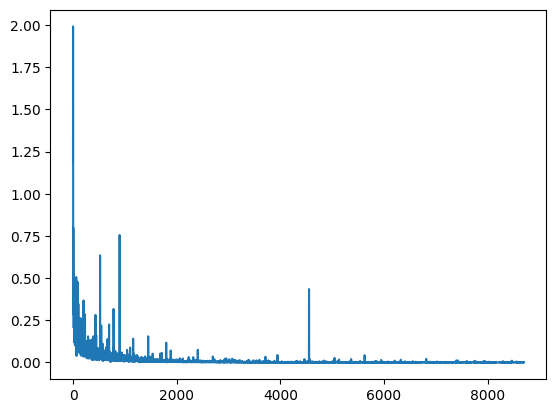

In [10]:
plt.plot(loss_list)

Plot the predictions $\hat y$ against the targets $y$.

In [13]:
yhat = net(x)

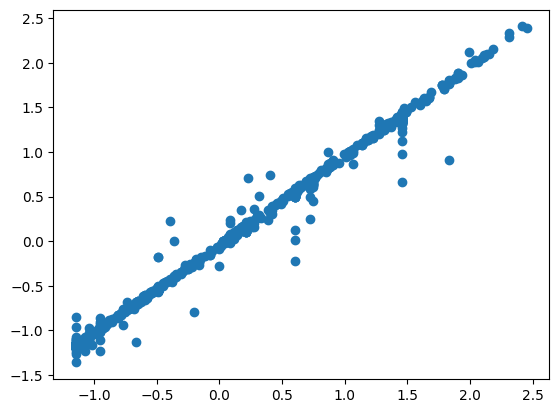

In [14]:
plt.scatter(y.cpu().detach().numpy(),yhat.cpu().detach().numpy())

Calculate the Pearson's correlation between your prediction and the target over the training data.

In [11]:
#print('train',np.corrcoef(train_y.cpu().detach().numpy()[:,0],net(train_x).cpu().detach().numpy()[:,0])[0,1])
print('test',np.corrcoef(test_y.cpu().detach().numpy()[:,0],net(test_x).cpu().detach().numpy()[:,0])[0,1])
print('valid',np.corrcoef(valid_y.cpu().detach().numpy()[:,0],net(valid_x).cpu().detach().numpy()[:,0])[0,1])

RuntimeError: cannot reshape tensor of 0 elements into shape [0, -1] because the unspecified dimension size -1 can be any value and is ambiguous

In [12]:
plt.scatter(test_y.cpu().detach().numpy(),net(test_x).cpu().detach().numpy())

RuntimeError: cannot reshape tensor of 0 elements into shape [0, -1] because the unspecified dimension size -1 can be any value and is ambiguous

Load `hc.nc`, containing heat content of the upper ocean, and use it as a second input channel to the network. Does this improve performance on the training data?

In [ ]:
hc = xr.open_dataset('hc.nc',decode_times=False)
xhc = torch.tensor(hc.temp.values[:-4], dtype=torch.float32)
xhc = (xhc-xhc.mean())/xhc.std()
xhc = xhc.unsqueeze(1)
xc = torch.cat((xc,xhc),dim=1)

In [ ]:
dataset = TensorDataset(xc, yc)  # combine the inputs and outputs into a PyTorch Dataset object
# create a dataloader to serve up batches of 8 data point for training
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
net = ConvNet(input_channels=2)


for x_batch, y_batch in data_loader:
  yhat = net(xc)
  break

print(yhat.shape)

torch.Size([1232, 1])


In [ ]:
n_epochs = 300
learning_rate = 0.001  # adjust this if necessary

lossfunc = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

loss_list = []

for epoch in tqdm(range(n_epochs)):
    for batch_index, batch in enumerate(data_loader):
        # note that each time this loop is run through, the order of the data is randomly permuted!
        x_batch, y_batch = batch
        optimizer.zero_grad()

        yhat_batch = net(x_batch)
        loss = lossfunc(yhat_batch,y_batch)
        loss_list.append(loss.detach().numpy())

        loss.backward()
        optimizer.step()  # this will update parameters using torch.no_grad()
        optimizer.zero_grad()

100%|██████████| 300/300 [10:01<00:00,  2.01s/it]


In [ ]:
yhat = net(xc)
np.corrcoef(yc.detach().numpy()[:,0],yhat.detach().numpy()[:,0])[0,1]

0.9110140176661191

Yes! It improves the performance

**Optional (+15% max. points)** Include two previous time steps as input for a total of 6 input channels.

In this case, we were able to load all of the training data into memory and store it in pytorch tensors. What if the training data were too big to fit into memory all at once? What could we do then? Propose a potential solution to this problem, and describe in words (or if you like, code) roughly how it would work.